# 군집 평가(Cluster Evaluation)
#### 앞선 붓꽃 데이터의 경우 결과값을 뜻하는 타깃 레이블이 있어서, 군집화 결과가 얼마나 잘 되었는지 알 수 있었다.
#### 하지만, 대부분의 군집 데이터 세트는 비교할만한 타깃 레이블을 가지고 있지 않다
#### 또, 분류와 비슷해 보이겠지만 성격이 매우 다르다.
#### 군집화는 데이터 내의 별도의 그룹을 찾아 새로운 의미를 부여하거나, 분류 값에 속하더라도 그 안에서 세부적인 군집화를 추구하거나 서로 다른 분류 값도 더 넓은 군집화에 속하는 영역을 가지고 있다.
#### 그렇다면 군집화가 효율적으로 잘 됐는지 평가할 수 있는 지표는 대표적으로 실루엣 분석이 있다. (비지도학습 특성상 어떤 지표라도 정확하게 성능을 평가하기 힘들다)

## 실루엣 분석
#### 각 군집 간의 거리가 얼마나 효율적으로 분리돼 있는지를 나타낸다.
#### 여기서 효율적 -> 다른 군집과의 거리는 떨어져 있고 동일 군집끼리의 데이터는 서로 가깝게 잘 뭉쳐있다는 것
#### 실루엣 계수를 기반으로 하는데, 개별 데이터가 가지는 군집화 지표이다
#### 해당 데이터가 같은 군집 내의 데이터와 얼마나 가깝게 군집화돼 있고, 다른 군집의 데이터와는 얼마나 멀리 분리돼 있는지 나타내는 지표이다.
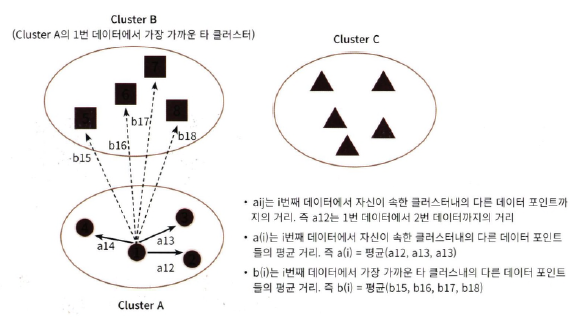

#### i번째 데이터 포인트의 실루엣 계수 값 s(i)는 아래와 같이 정의한다.
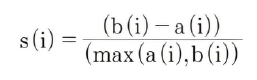
#### *a(i) : 해당 데이터 포인터와 같은 군집 내에 있는 다른 데이터 포인트와의 거리를 평균한 값
#### *b(i) : 해당 데이터 포인터가 속하지 않은 군집 중 가장 가까운 군집과의 평균 거리
#### *b(i) - a(i) : 두 군집간의 거리
#### *MAX( a(i), b(i)) : 정규화 하기 위한 값

#### 실루엣 계수는 -1에서 1 사이의 값을 가지며, 1로 가까워질수록 근처의 군집과 더 멀리 떨어져 있다는 것이고, 0에 가까울수록 근처의 군집과 가까워진다는 의미다
#### 마이너스(-)값은 아에 다른 군집에 데이터 포인트가 할당되었다는 의미다.

#### 사이킷런은 실루엣 분석을 위해 아래와 같은 메서드를 제공한다.
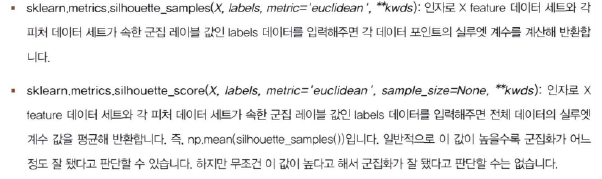

#### 좋은 군집화가 되려면 아래 기준을 만족해야 한다.
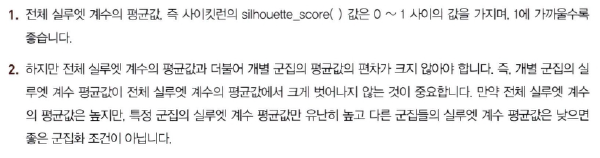

## 붓꽃 데이터 세트를 이용한 군집 평가

In [6]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
# 실루엣 분석 metric 값을 구하기 위한 API 추가
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# 붓꽃 데이터 세트 피처들을 DataFrame 변환. 
iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)

# 군집화 수행
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0)
kmeans.fit(irisDF)

# 개별 데이터에 대한 군집 결과를 cluster 컬럼으로 DataFrame에 저장. 
irisDF['cluster'] = kmeans.labels_

score_samples = silhouette_samples(iris.data, irisDF['cluster'])
# print(score_samples)

irisDF['silhouette_coeff'] = score_samples

average_socre = silhouette_score(iris.data, irisDF['cluster'])
print(average_socre)
irisDF.head()

0.5528190123564094


,sepal_length,sepal_width,petal_length,petal_width,cluster,silhouette_coeff
0,5.1,3.5,1.4,0.2,1,0.852955
1,4.9,3.0,1.4,0.2,1,0.815495
2,4.7,3.2,1.3,0.2,1,0.829315
3,4.6,3.1,1.5,0.2,1,0.805014
4,5.0,3.6,1.4,0.2,1,0.849302


In [7]:
irisDF.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.417320
1    0.798140
2    0.451105
Name: silhouette_coeff, dtype: float64

#### 1번 군집은 실루엣 계수 평균 값이 0.79인데 반해, 0/2번 군집은 상대적으로 평균값이 낮다.

## 군집별 평균 실루엣 계수의 시각화를 통한 군집 개수 최적화 방법
#### 전체 데이터의 평균 실루엣 계수가 높다고 해서 최적은 아니다 -> 개별 군집별 적당히 분리된 거리와 군집 내의 데이터가 서로 뭉쳐있는 경우 K-평균의 적절한 군집 개수가 설정되었다고 한다.

#### 군집 개수에 따른 군집별 평균 실루엣 계수 값을 아래와 같이 시각화 해본다.

In [9]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

#### visualize_silhouette()는 내부 파라미터로 여러 개의 군집 개수를 리스트로 가지고, 피처 데이터 세트를 가진다.
#### 만약, 군집의 개수에 따른 군집별 평균 실루엣 계수 값을 알고 싶다면 아래와 같이 호출하자

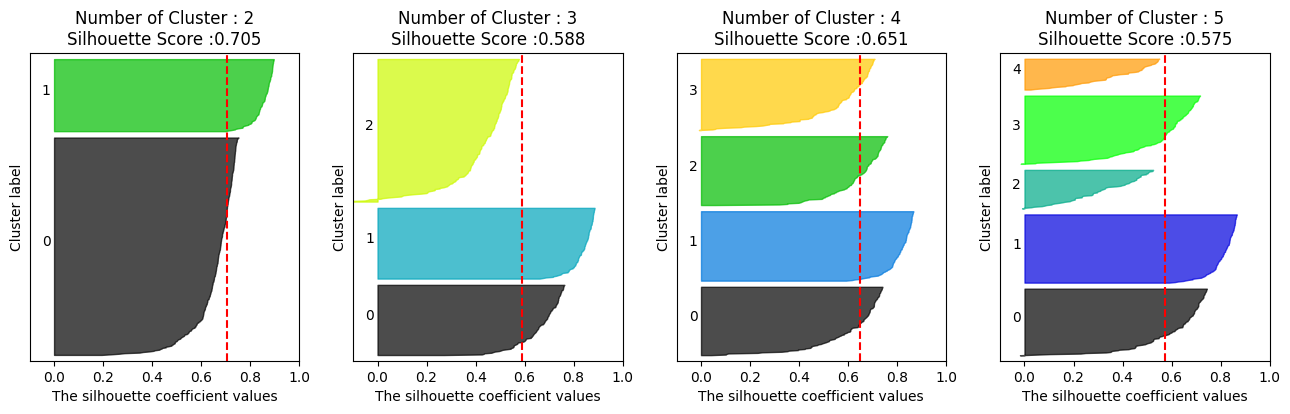

In [10]:
# make_blobs 을 통해 clustering 을 위한 4개의 클러스터 중심의 500개 2차원 데이터 셋 생성  
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, \
                  center_box=(-10.0, 10.0), shuffle=True, random_state=1)  

# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([ 2, 3, 4, 5], X)

#### *군집개수 2개일 때
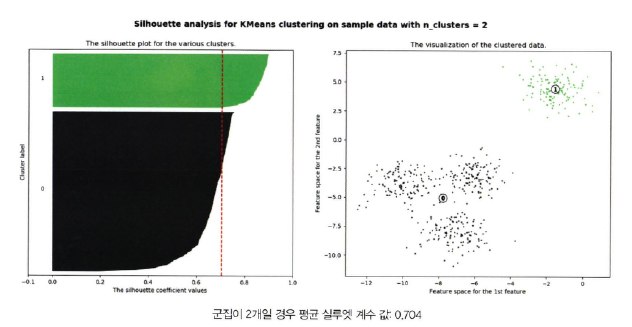

#### *군집개수 3개일 때
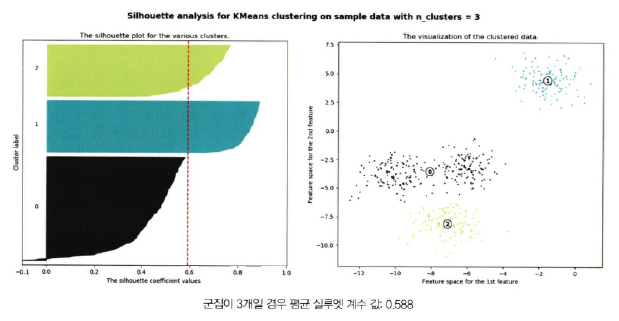

#### *군집개수 4개일 때
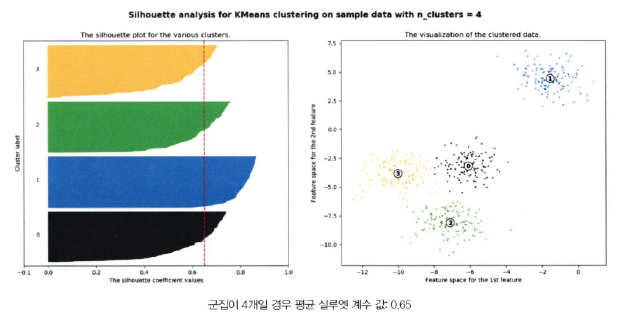

#### 군집이 4개일 때, 모든 레이블의 평균 실루엣 계수도 균일하고, 데이터도 균일하다.

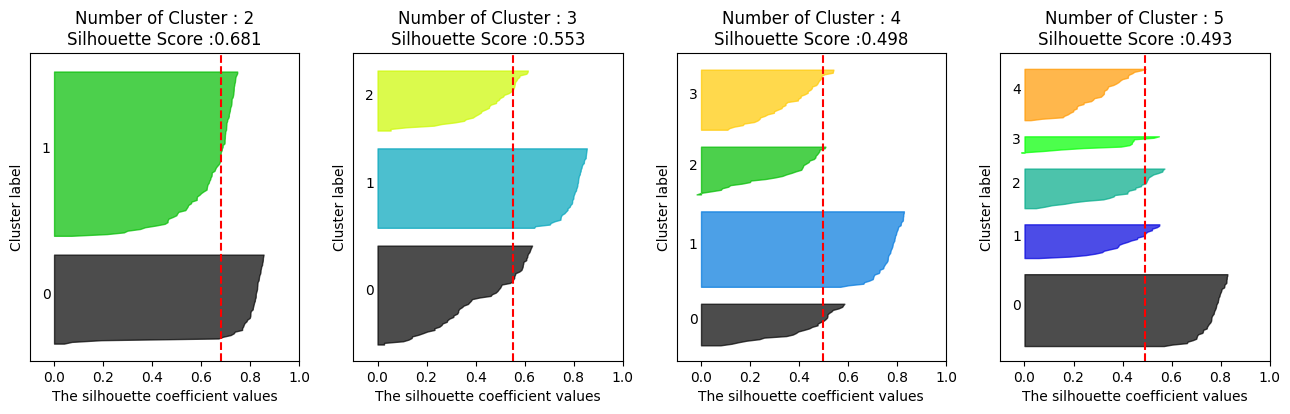

In [11]:
from sklearn.datasets import load_iris

iris=load_iris()
visualize_silhouette([ 2, 3, 4,5 ], iris.data)

#### 붓꽃 데이터의 경우 군집이 2개일 때 가장 좋다.

#### 실루엣 계수를 통한 K-평균 군집 평가 방법은 직관적으로 이해하기 쉬우나, 데이터 별로 다른 데이터와의 거리를 계산해야 하기 때문에 데이터 양이 늘어나면 수행시간이 크게 늘어난다.
#### 몇 만건의 이상의 데이터에 대해서는 메모리 부족 현상이 발생할 수 있다. -> 군집별로 임의의 데이터를 샘플링해 실루엣 계수를 평가해야 한다.